# Refine Round 2

Now we have two sets of annotations let's create new annotations using each of them

In [1]:
%cd ..

/home/bookfinder


In [2]:
import numpy as np
import pandas as pd

from datasets import Dataset

from sentence_transformers.losses import CosineSimilarityLoss

from setfit import SetFitModel, SetFitTrainer

from pathlib import Path

# Train the model

## Read in existing annotations

In [3]:
dir_annotations = Path('data/00_annotations/03_book_binary/')

[x.name for x in dir_annotations.glob('*.jsonl')]

['hnbook_classify.jsonl', 'hnbook_binary_02.jsonl']

In [4]:
df_in = pd.concat([
    pd.read_json(path, lines=True)
    for path in dir_annotations.glob('*.jsonl')])

In [5]:
counts = df_in.answer.value_counts()
counts

reject    153
accept     29
ignore      6
Name: answer, dtype: int64

## Stratified Sample

Create a 1:1 sample of reject and accept

In [6]:
n_sample = counts.loc[['reject', 'accept']].min()

n_sample

29

In [7]:
df_train = (
    df_in
    .query('answer != "ignore"')
    .groupby('answer', group_keys=False)
    .apply(lambda x: x.sample(min(len(x), n_sample)))
)

df_train.answer.value_counts()

accept    29
reject    29
Name: answer, dtype: int64

## Train the model

We'll use [SetFit](https://huggingface.co/blog/setfit) which is fast and good for few-shot text classification like this.

In [8]:
train_dataset = Dataset.from_pandas(df_train)
train_dataset

Dataset({
    features: ['text', 'meta', '_input_hash', '_task_hash', 'label', '_view_id', 'answer', '_timestamp', '__index_level_0__'],
    num_rows: 58
})

Use `all-MiniLM-L6-v2` which is very fast, while still quite accurate (based on the SentenceTransformers [benchmarks](https://www.sbert.net/docs/pretrained_models.html)).

In [9]:
model = SetFitModel.from_pretrained("sentence-transformers/all-MiniLM-L6-v2")

model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


We'll leave all these as their default

In [10]:
trainer = SetFitTrainer(
    model=model,
    train_dataset=train_dataset,
    eval_dataset=None,
    loss_class=CosineSimilarityLoss,
    metric="accuracy",
    batch_size=16,
    num_iterations=20, # The number of text pairs to generate for contrastive learning
    num_epochs=1, # The number of epochs to use for constrastive learning
    column_mapping={"text": "text", "answer": "label"} # Map dataset columns to text/label expected by trainer

)

In [11]:
trainer.train()

Applying column mapping to training dataset
***** Running training *****
  Num examples = 2320
  Num epochs = 1
  Total optimization steps = 145
  Total train batch size = 16


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Iteration:   0%|          | 0/145 [00:00<?, ?it/s]

In [12]:
model.save_pretrained('data/06_models/setfit_1')

# Predict

Now let's perform inference with our trained model on our data to annotate.

In [13]:
df = (
    pd.read_parquet('data/02_intermediate/hn_enriched.parquet')
    .query('bucket<3 & text_length > 0')
)

In [14]:
text = df.clean_text.to_list()

Get the column corresponding to 'accept'

In [15]:
model.model_head.classes_

array(['accept', 'reject'], dtype='<U6')

In [16]:
accept_idx = list(model.model_head.classes_).index('accept')
accept_idx

0

Calculate the accept probabilities

In [17]:
%%time
probs = model.predict_proba(text)[:,accept_idx]

CPU times: user 2min 9s, sys: 7.92 s, total: 2min 17s
Wall time: 1min 19s


In [18]:
df['prob'] = probs

## Check the results

In [19]:
pd.options.display.max_colwidth = 1000

In [20]:
df.sort_values('prob', ascending=False)[['clean_text']][:10]

,clean_text
id,
26099778,"Someone on HN mentioned the book 'Titanosaur: Discovering the World's Largest Dinosaur' written by the two paleontologists who led the discovery - José Luis Carballido and Diego Pol. It's illustrated and seems to have very good reviews.\n\nhttps://kids.scholastic.com/kids/book/titanosaur-by-jose-luis-carballido/\n\nPersonally, when I was a teen, the first 3 Jurassic Park films whirled my brain and had nice vivid dreams about the island and dinos."
26753531,"As someone whose great uncles worked in the steel factories nearby, whose parents before that labored in the cotton fields, I can also testify the multi-century efforts of Black workers who fought the “hands that was fedding them”. America's Johannesburg [1] and Hammer and Hoe [2] for reference.\n\n[1] https://ugapress.org/book/9780820356273/americas-johannesburg/\n\n[2] https://uncpress.org/book/9781469625485/hammer-and-hoe/"
26756574,"It seems this book's colours were hand-painted, but I might as well mention two famous mid-C19 examples of colour printing, when (IIRC; I am not an expert) high-quality colour printing was still very expensive and rare:\n\n* the ""Sobieski Stewarts'"" dodgy Vestiarium Scoticum: https://en.wikipedia.org/wiki/Vestiarium_Scoticum\n\n> It was from Eilean Aigas, in 1842, that the brothers at last published their famous manuscript, Vestiarium Scoticum . It appeared in a sumptuous edition limited to fifty copies. The series of coloured illustrations of tartans was the first ever to be published and was a triumph over technical difficulties. These illustrations were executed by a new process of ‘machine printing’ and, in the words of a scholar writing fifty years later, ‘for beauty of execution and exactness of detail have not been excelled by any method of colour-printing subsequently invented’.\n\n> Hugh Trevor-Roper, ""The Invention of Tradition: The Highland Tradition of Scotland""\n\n..."
26937872,"If anyone wants to read about mystery/crime investigation in Ancient Rome, the SPQR series is a bunch of fun fictional books (of questionable historical accuracy):\n\n> The stories are told in first-person form by Senator Decius Caecilius Metellus the Younger (born c 90-95 BC), nephew of Metellus Pius and member of the powerful Caecilius Metellus family of the Roman Senate. The stories are told in flashback-form by the old Decius, writing during the reign of Augustus Caesar. The stories range from 70 BC (The King's Gambit) to 20 BC (""The King of Sacrifices"").\n\n* https://en.wikipedia.org/wiki/SPQR_series\n\nFor non-fiction, see Infamy: The Crimes of Ancient Rome by Jerry Toner:\n\n> Join the historian Jerry Toner on a detective's hunt to discover the extent of Rome's crimes.\nFrom the sexual peccadillos of Tiberius and Nero to the chances of getting burgled if you left your apartment unguarded (pretty high, especially if the walls were thin enough to knock through) he leaves no st..."
28060693,"The one really first rate recent SF novel I can recall is: ""This is how you lose the time war"" [0] by Amal El-Mohtar and Max Gladstone. It's far from being Hard SF if you like that (I do) but the humour and poetry of it won me over very fast. I bought it purely on the basis of the delicious title!\n\nThe ""Lady Astronaut"" series [1] by Mary Robinette Kowal is not first rate, but it is reliably entertaining and a fairly Hard SF alternate history with some interesting choices.\n\nI'm going to take a liberty and also recommend a much older SF book that I rarely see mentioned; ""Fiasco"" by Stanisław Lem. This one's all about the characterization and the big picture of humanity's fatal flaws. Not hard SF as such, but he tells a good tall tale when he needs to mess with space and time.\n\n[0] https://en.wikipedia.org/wiki/This_Is_How_You_Lose_the_Time_War\n\n[1] https://www.goodreads.com/series/193730-lady-astronaut-universe\n\n[1] https://en.wikipedia.org/wiki/Fiasco_(novel)"
26698876,"Not a biography, but a collection of memorial a

# Stratified sample for annotation.

We want to get some interesting examples to annotate.

If we pick at random, most won't have titles of books or works of art.
Instead sample equally from each decile to get a mixture of positives, negatives and borderline cases.

<AxesSubplot: >

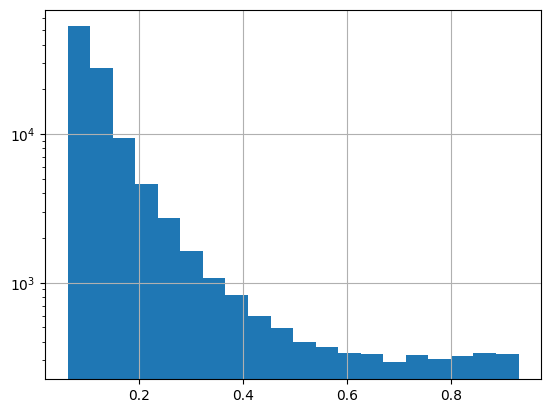

In [21]:
df['prob'].hist(bins=20, log=True)

In [22]:
df['bucket'] = (df['prob']*10).astype(int)

In [23]:
n_sample = 20

Remove the items that are already annotated

In [24]:
annotated_ids = [x['id'] for x in df_in['meta'].to_list()]

In [25]:
df_out = (
    df.loc[~df.index.isin(annotated_ids)]
    .groupby('bucket', group_keys=False)
    .apply(lambda x: x.sample(min(len(x), n_sample)))
    .sample(frac=1)
)

In [26]:
len(df_out)

200

In [27]:
df_out.bucket.value_counts()

2    20
0    20
1    20
7    20
4    20
8    20
3    20
6    20
9    20
5    20
Name: bucket, dtype: int64

Save to JSON

In [28]:
import json

with open('data/02_intermediate/hn_sample_2.jsonl', 'w') as f:
    for id, row in df_out.iterrows():
        data = {"text": row["clean_text"], "meta": {"id": id}}
        print(json.dumps(data), file=f)